# Preparing

In [1]:
import os
from gensim import models
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
from string import punctuation

from gensim.models import KeyedVectors
import numpy as np

import pickle

# Configuration

In [2]:
dataset_files = {}
dictionary_files = {}
model_patch = {}

# Target dataset (which is used for the true classification)
key_dataset = 'tea.xlsx'
non_coffee = 'content/stopwords/non-cofe.xlsx'

# *** Datasets ***
dataset_path = '/home/jupyter/work/resources/content/datasets/'
#dict_path = '/home/jupyter/work/resources/content/dictionaries/coffee_dict.xlsx'
dict_path = '/home/jupyter/work/resources/content/dictionaries/tea_dict.xlsx'

# *** Classifieng models ***
model_patch["rfc"] = "content/models/random_forest_classifier.pickle"
model_patch["sgd"] = "content/models/sgd_classifier_tea.pickle"
model_patch["sgd_sm"] = "content/models/sgd_classifier_sm.pickle"

# *** For saving ***
ab_save_patch = 'content/ab_analyse/'

# Dataset structure - used for the source datasets fields
req_str = 'text'

brand_weight_multiplicator = 48
non_category_weight_multiplicator = 1

# Load data

In [3]:
# *** Datasets loading***
for entry in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, entry)):
        dataset_files[entry] = dataset_path + entry

In [4]:
dictionary_src = pd.read_excel(dict_path, names=['brand_id', 'brand', 'spelled'], engine='openpyxl')
dictionary = pd.DataFrame(
    np.append(dictionary_src['spelled'].unique(), dictionary_src['brand'].unique()), columns=['text']
    )
dictionary.head(5)

,text
0,susan
1,Heladiv
2,черный дракон
3,Чёрный дракон
4,чёрный дракон


In [5]:
non_coffee_df = pd.read_excel(non_coffee, engine='openpyxl')
non_coffee_df.head(5)

,text
0,тесто тестов
1,яйца яйца
2,молоко молоко
3,сахар сахар
4,лайм лайм


In [6]:
# Define the positive dataset
positive_dataset = pd.read_excel(dataset_files[key_dataset], header=None, names=[req_str], engine='openpyxl')

# load brands
for _ in range(brand_weight_multiplicator):
    positive_dataset = pd.concat([positive_dataset, dictionary], sort=False)

positive_dataset['label'] = 1

positive_dataset

,text,label
0,чай,1
1,липтон,1
2,чай гринфилд,1
3,love is,1
4,черная смородина купить,1
...,...,...
2193,принйесса гита,1
2194,Голден Виктория,1
2195,корона российской империи,1
2196,Корона российской империи,1


In [7]:
# Define the negative dataset
cont_dataset = pd.DataFrame()

# Add non_coffee
for _ in range(non_category_weight_multiplicator):
    cont_dataset = pd.concat([cont_dataset, non_coffee_df], sort=False)

cont_dataset.head(5)

,text
0,тесто тестов
1,яйца яйца
2,молоко молоко
3,сахар сахар
4,лайм лайм


In [8]:
# Add other non coffee sets
for key, value in dataset_files.items():
    if key != key_dataset:
        tmp = pd.read_excel(value, header=None, names=[req_str], engine='openpyxl')
        
        # Checking that your target dataset does not contain the fields from other sets
        positive_dataset.drop(positive_dataset[positive_dataset[req_str].isin(tmp[req_str])].index, inplace=True)
        
        # Add a new part to the negative dataset 
        cont_dataset = pd.concat([cont_dataset, tmp], sort=False)

cont_dataset = cont_dataset.sample(frac = 1).reset_index(drop=True)
cont_dataset['label'] = 0
cont_dataset.head()

,text,label
0,мягкая игрушка hasbro котенок,0
1,lego 5593 купить,0
2,игрушка руль купить,0
3,купить игрушки сильвания фэмили дешево в москве,0
4,бионикл из старых,0


In [9]:
# Let us define the train data set which we are going to use during our model fitting, 
# and the validation dataset for the following checking of the model.
    
# Train Dataset
df_train = pd.concat([
    positive_dataset[:(round(positive_dataset.shape[0]*0.75))],
    cont_dataset[:(round(cont_dataset.shape[0]*0.75))]
], sort=False).sample(frac = 1).reset_index(drop=True)

# Validation dataset
df_val = pd.concat([
    positive_dataset[(round(positive_dataset.shape[0]*0.75)):],
    cont_dataset[(round(cont_dataset.shape[0]*0.75)):]
], sort=False).sample(frac = 1).reset_index(drop=True)

# Preprocess data analysing

In [10]:
df_train.head()

,text,label
0,барби агенты шпионы,0
1,волк фигурка игрушка,0
2,памперсы-трусы для детей 4 купить,0
3,лего домик для животных,0
4,купить памперс 4 86 шт цена,0


In [11]:
df_train = df_train.astype(str)
df_val = df_val.astype(str)

In [12]:
print("------")
print("Basic statistics")
print("")
print("Train shape: ", df_train.shape)
print("Validation shape: ", df_val.shape)
true_label = (df_train.label.value_counts() / df_train.shape[0])[1]
false_label = (df_train.label.value_counts() / df_train.shape[0])[0]
print(f"Class distribution:\n True = {round(true_label*100, 2)}%,\n False = {round(false_label*100, 2)}%")
print("")
print("------")
print("Label basic statistics")
print("")
print(df_train['label'].value_counts())
print("")
print("------")
print("Text basic statistics")
print("")
print('Total unique reqests counts:', len(df_train[req_str].unique()))
print("Mean amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (train dataset): ", df_train[req_str].str.len().mean())
print("Max amount of words in sentences (train dataset): ", df_train[req_str].str.split().map(len).max())
print("Max chars amount in sentences (train dataset): ", df_train[req_str].str.len().max())
print("Mean amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).mean())
print("Mean chars amount in sentences (validation dataset): ", df_val[req_str].str.len().mean())
print("Max amount of words in sentences (validation dataset): ", df_val[req_str].str.split().map(len).max())
print("Max chars amount in sentences (validation dataset): ", df_val[req_str].str.len().max())
print("")
print("------")

------
Basic statistics

Train shape:  (525268, 2)
Validation shape:  (175090, 2)
Class distribution:
 True = 15.18%,
 False = 84.82%

------
Label basic statistics

0    445516
1     79752
Name: label, dtype: int64

------
Text basic statistics

Total unique reqests counts: 446838
Mean amount of words in sentences (train dataset):  3.2085164144779426
Mean chars amount in sentences (train dataset):  21.620203400930574
Max amount of words in sentences (train dataset):  16
Max chars amount in sentences (train dataset):  100
Mean amount of words in sentences (validation dataset):  3.2082757439031355
Mean chars amount in sentences (validation dataset):  21.62053229767548
Max amount of words in sentences (validation dataset):  16
Max chars amount in sentences (validation dataset):  99

------


<AxesSubplot:title={'center':'Amount of words in sentences'}>

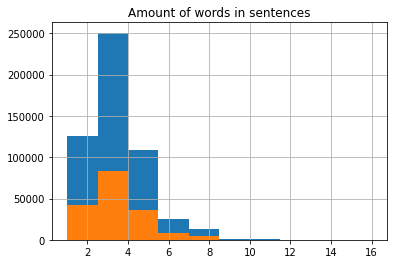

In [13]:
df_train[req_str].str.split().map(len).hist().set_title('Amount of words in sentences')
df_val[req_str].str.split().map(len).hist()

<AxesSubplot:title={'center':'Chars amount in sentences'}>

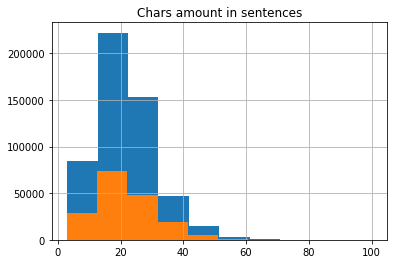

In [14]:
df_train[req_str].str.len().hist().set_title('Chars amount in sentences')
df_val[req_str].str.len().hist()

In [15]:
df_train.isnull().values.any(), df_val.isnull().values.any(),

(False, False)

# Preprocess data

In [16]:
# russian_stopwords = set(stopwords.words("russian"))

# def preprocess_text(text):
#     #tokens = mystem.lemmatize(text.lower())
#     tokens = nltk.tokenize.word_tokenize(text.lower())
#     tokens = [token for token in tokens if token not in russian_stopwords\
#               and token != " " \
#               and token.strip() not in punctuation]
    
#     text = " ".join(tokens)
    
#     return text

# def preprocess_tokens(text):
#     tokens = nltk.tokenize.word_tokenize(text.lower())
#     tokens = [token for token in tokens if token not in russian_stopwords\
#               and token != " " \
#               and token.strip() not in punctuation]
    
#     return tokens

# df_train['tokens'] = df_train[req_str].apply(preprocess_tokens)
# df_val['tokens'] = df_train[req_str].apply(preprocess_tokens)
# df_train['cleaned_text'] = df_train[req_str].apply(preprocess_text)
# df_val['cleaned_text'] = df_val[req_str].apply(preprocess_text)

In [17]:
# df_train

In [18]:
# df_val

In [19]:
# def cnt_uniq(col):
#     count = set()
#     for line in col:
#         count |= set(line)
#     return len(count)

# print("------")
# print("Unique words in df_train.tokens: ", cnt_uniq(df_train.tokens))
# print("Unique words in df_val.tokens: ", cnt_uniq(df_val.tokens))
# print("------")

# PipeLines

In [20]:
sgd_ppl_clf_bin = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1, 2), 
        analyzer='word',  
        min_df=5, 
        max_features=1000)),
    ('sgd_clf', SGDClassifier(
        random_state=None, 
        class_weight='balanced', 
        loss='log', 
        penalty='l2',
    ))])

# Embedding and classification

In [21]:
# sgd_clf

x_train_bin = df_train[req_str]
y_train_bin = df_train['label'].astype('int')

sgd_ppl_clf_bin.fit(x_train_bin, y_train_bin)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                   

# Check the classifier 

In [22]:
def chk_classifier(prediction, validation):

    print("*** Check and calculate the metrics ourselves ***")

    # model prediction result
    a_check = prediction
    # Validation resuls  
    b_check = np.array(validation)
    # проверим размерность
    print("Check shapes of the prediction and Y validation:", a_check.shape, b_check.shape)

    # True Negative Predicted - false, Real - false
    ab_diff_tn = []
    # False Negative Predicted - false, Real - True
    ab_diff_fn = []
    # False positive Predicted - True, Real - False
    ab_diff_fp = []
    # True positive Predicted - True, Real - True
    ab_diff_tp = []

    print('')
    print('******')

    for indx in range(len(a_check)):
        if (a_check[indx] == True):
            if (b_check[indx] == True):
                ab_diff_tp.append(indx)
            else:
                ab_diff_fp.append(indx)
        else:
            if (b_check[indx] == True):
                ab_diff_fn.append(indx)
            else:
                ab_diff_tn.append(indx)

    tn =  len(ab_diff_tn)
    fn =  len(ab_diff_fn)
    fp =  len(ab_diff_fp)
    tp =  len(ab_diff_tp)

    print(f"True Negative:  {tn}  | False Positive:  {fp}")
    print(f"False Negative: {fn}   | True Positive:  {tp}")

    print(f"Precision = {tp} / ( {tp} + {fp} ) = {round(tp/(tp+fp), 2)}")
    print(f"Recall = {tp} / ( {tp} + {fn} ) = {round(tp/(tp+fn), 2) }")

    print('')
    print('******')
    print(f"Accurracy = {round(metrics.accuracy_score(a_check, b_check), 2) }")
    print(f"F1 Score = {round(metrics.f1_score(a_check, b_check, average='weighted'), 2) }")
    

In [23]:
print("*** Check the model by the validation data ***")

predicted_sgd = sgd_ppl_clf_bin.predict(df_val[req_str])
print(metrics.classification_report(predicted_sgd, df_val['label'].astype('int')))

*** Check the model by the validation data ***
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    137499
           1       1.00      0.71      0.83     37591

    accuracy                           0.94    175090
   macro avg       0.96      0.85      0.89    175090
weighted avg       0.94      0.94      0.93    175090



In [24]:
chk_classifier(predicted_sgd.view(), df_val['label'].astype('int'))

*** Check and calculate the metrics ourselves ***
Check shapes of the prediction and Y validation: (175090,) (175090,)

******
True Negative:  137475  | False Positive:  11031
False Negative: 24   | True Positive:  26560
Precision = 26560 / ( 26560 + 11031 ) = 0.71
Recall = 26560 / ( 26560 + 24 ) = 1.0

******
Accurracy = 0.94
F1 Score = 0.93


In [25]:
pickle.dump(sgd_ppl_clf_bin, open(model_patch["sgd_sm"], 'wb'))

# Create model on all data

In [26]:
# ]).sample(frac = 1).reset_index(drop=True)

# x_train_bin = pd.concat([
#     df_train[req_str],
#     df_val[req_str]
# ])
                         
# y_train_bin = pd.concat([
#     df_train['label'].astype('int'),
#     df_val['label'].astype('int')
# ])

df_train_big = pd.concat([
    positive_dataset,
    cont_dataset
], sort=False).sample(frac = 1).reset_index(drop=True)

df_train_big = df_train_big.astype(str)

df_train_big

,text,label
0,детские машинки девчачьи,0
1,пасхальные яйца игрушка,0
2,шоколадный цвет дерева,0
3,игрушка складной автомат,0
4,гитта,1
...,...,...
700353,star wars starkillers,0
700354,гибкий трек 1toy 317 деталей,0
700355,fisher price попрыгунчик,0
700356,детские машинки в городе,0


In [27]:
x_train_bin = df_train_big[req_str]
y_train_bin = df_train_big['label'].astype('int')

In [28]:
# df_train[req_str].shape, df_val[req_str].shape, x_train_bin.shape

In [29]:
# df_train['label'].shape, df_val['label'].shape, y_train_bin.shape

In [30]:
y_train_bin[y_train_bin == 1].value_counts()

1    106336
Name: label, dtype: int64

In [31]:
sgd_ppl_clf_bin.fit(x_train_bin, y_train_bin)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1000,
                                 min_df=5, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 SGDClassifier(alpha=0.0001, average=False,
                               class_weight='balanced', early_stopping=False,
                               epsilon=0.1, eta0=0.0, fit_intercept=True,
                               l1_ratio=0.15, learning_rate='optimal',
                   

In [32]:
pickle.dump(sgd_ppl_clf_bin, open(model_patch["sgd"], 'wb'))